In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


%matplotlib inline

### Load Data

In [132]:
data = np.load("data/mds-population.npz")
distance = data['D'] # Distance matrix
labels = data['population_list'] # List of populations
print(distance) 
print(labels) 

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


### Multidimensional Scaling (MDS)

(42, 2)


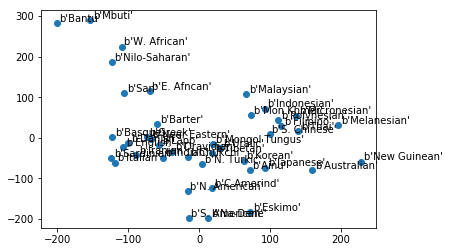

In [133]:
distance = MDS(n_components=2, dissimilarity='precomputed').fit_transform(distance)
print(distance_mds.shape)
dist_x, dist_y = zip(*distance_mds)
plt.scatter(dist_x, dist_y)
pan = 4
for i, txt in enumerate(labels):
    plt.annotate(txt, (dist_x[i] + pan, dist_y[i] + pan))

### K-means on 2D embedding

------------------------ Cluster 0 -------------------------------
[b'Mon Khmer' b'Thai' b'Indonesian' b'Malaysian' b'Filipino' b'S. Chinese'
 b'Melanesian' b'Micronesian' b'Polynesian' b'New Guinean' b'Australian'] 

------------------------ Cluster 1 -------------------------------
[b'Barter' b'Indian' b'Iranian' b'Near Eastern' b'Dravidian' b'Basque'
 b'Lapp' b'Sardinian' b'Danish' b'English' b'Greek' b'Italian'] 

------------------------ Cluster 2 -------------------------------
[b'Uralic' b'Ainu' b'Japanese' b'Korean' b'Mongol Tungus' b'Tibetan'
 b'N. Turkic' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi'] 

------------------------ Cluster 3 -------------------------------
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Mbuti'] 



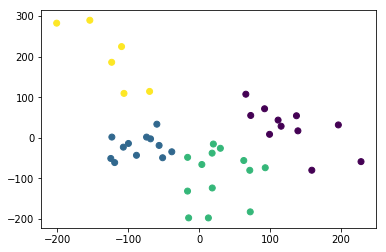

In [134]:
clusters = 4
kmeans = KMeans(n_clusters=clusters, random_state=42).fit(distance_mds)
plt.scatter(dist_x, dist_y, c=kmeans.labels_)

for i in range(clusters):
    print("------------------------ Cluster", i, "-------------------------------")
    print(labels[np.where(kmeans.labels_ == i)],"\n")

### Hierarchical Clustering

------------------------ Cluster 0 -------------------------------
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Mbuti'] 

------------------------ Cluster 1 -------------------------------
[b'Mon Khmer' b'Thai' b'Indonesian' b'Malaysian' b'Filipino' b'S. Chinese'
 b'Melanesian' b'Micronesian' b'Polynesian' b'New Guinean' b'Australian'] 

------------------------ Cluster 2 -------------------------------
[b'Barter' b'Indian' b'Iranian' b'Near Eastern' b'Dravidian' b'Basque'
 b'Lapp' b'Sardinian' b'Danish' b'English' b'Greek' b'Italian'] 

------------------------ Cluster 3 -------------------------------
[b'Uralic' b'Ainu' b'Japanese' b'Korean' b'Mongol Tungus' b'Tibetan'
 b'N. Turkic' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi'] 



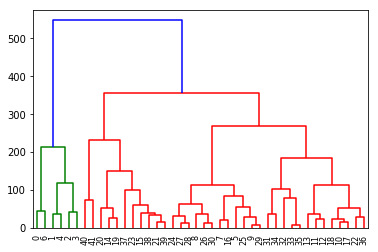

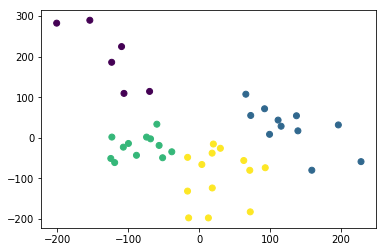

In [136]:
Z = linkage(distance, 'complete')
dn = dendrogram(Z)
# fclusters = fcluster(Z, 1100, criterion='distance')
fclusters = fcluster(Z, 4, criterion='maxclust')

for i in range(clusters):
    print("------------------------ Cluster", i, "-------------------------------")
    print(labels[np.where(fclusters == i + 1)],"\n")
    
plt.figure()
plt.scatter(dist_x, dist_y, c=fclusters)

### K-medoids

In [137]:
# The K-medoids implementation refers to https://github.com/salspaugh/machine_learning/blob/master/clustering/kmedoids.py
import numpy as np
import random

def cluster(distances, k=3):
    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

------------------------ Cluster 0 -------------------------------
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Mbuti'] 

------------------------ Cluster 1 -------------------------------
[b'Uralic' b'Ainu' b'Japanese' b'Korean' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'N. Turkic' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'New Guinean' b'Australian'] 

------------------------ Cluster 2 -------------------------------
[b'Mon Khmer' b'Thai' b'Indonesian' b'Malaysian' b'Filipino' b'S. Chinese'
 b'Melanesian' b'Micronesian' b'Polynesian'] 

------------------------ Cluster 3 -------------------------------
[b'Barter' b'Indian' b'Iranian' b'Near Eastern' b'Basque' b'Lapp'
 b'Sardinian' b'Danish' b'English' b'Greek' b'Italian'] 



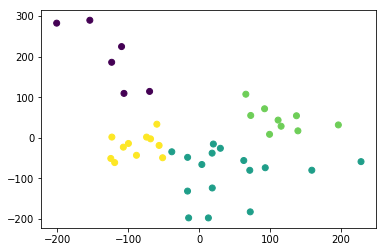

In [186]:
medoid_labels, medoids = cluster(data_distance, 4)

# handle ranking
groups = np.unique(medoid_labels)

for i in range(clusters):
    print("------------------------ Cluster", i, "-------------------------------")
    print(labels[np.where(medoid_labels == groups[i])],"\n")
    
plt.figure()
plt.scatter(dist_x, dist_y, c=medoid_labels)